In [36]:
import pickle
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#from shapely.geometry import Polygon
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split 
from sklearn import tree
dataset = pickle.load(open('mutag_processed.pkl', 'rb'))

In [53]:
class merged:
    def __init__(self, data):
        self.data=data
    
    
    def adjacency_ith_molecule(self, i):
        G = nx.Graph()  # create a graph object
        list_edg = []   # create empty list of edges
        list_bond_type = [] # create empty list of bond types

        # Running through edge_list entry
        for elem in self.data[i]['edge_list']:
            list_edg.append(elem[0])  # add each edge
            list_bond_type.append(elem[1])

        G.add_edges_from(list_edg)  # add edges to the graph object

        #### BOND TYPES
        nx.set_edge_attributes(G, values = 0, name = 'bond_type')  # add null bond type values
        for j, e in enumerate(list(G.edges())):
            u, v = e[0], e[1]
            G[u][v]['bond_type']= list_bond_type[j] # adding bond types


        #### VERT TYPES
        vert_type = list(self.data[i]['vert_type']) # atoms types
        nx.set_node_attributes(G, values = 0, name = 'vert_type') # add null vert types
        for k, node in enumerate(list(G.nodes(data=True))):
            node[1]['vert_type'] = vert_type[k]


        #### ADJACENCY MATRIX
        A = nx.adjacency_matrix(G)  # this gives a sparse matrix object
        A_dense = A.todense() # this gives a dense matrix-type object
        A_array = np.array(A_dense) # this gives an array-type adjacency matrix

        #### EIGENVALUES OF A 
        A_evalues, A_evectors = np.linalg.eig(A_array)

        #### Laplacian MATRIX
        L = nx.laplacian_matrix(G)  # this gives a sparse matrix object
        L_dense = L.todense() # this gives a dense matrix-type object
        L_array = np.array(L_dense) # this gives an array-type adjacency matrix
        #### EIGENVALUES OF A 
        L_evalues, L_evectors = np.linalg.eig(L_array)
        
        #### Some Fundamental things for PENTAGON & HEXAGON
        A_5 = np.linalg.matrix_power(A_array,5)
        A_6 = np.linalg.matrix_power(A_array,6)
        trace5 = np.trace(A_5)
        trace6 = np.trace(A_6)
        no_edge = len(self.data[i]['edge_list'])    
        F1 = 0
        F3 = 0
        F4 = 0
        for i in range(np.size(A_array,1)):
            k_i = sum(A_array[i]) # degree of node
            F1 = F1+k_i*(k_i-1)/2
            F4 = F4+k_i*(k_i-1)*(k_i-2)/6
            for j in range(np.size(A_array,1)):
                if A_array[i][j]==1:
                    k_j = sum(A_array[j])
                    F3 = F3+(k_i-1)*(k_j-1)/2

        #### NUMBER OF PENTAGON just a formula
        no_pentagon = (1/10)*trace5

        #### NUMBER OF HEXAGON just a formula
        no_hexagon = (1/12)*(trace6-2*no_edge-12*F1-6*F3-12*F4)

        return G, A_evalues, L_evalues, no_pentagon, no_hexagon
    
    def sum_Attributes(self):
        no_mols = len(self.data) #188

        # Initialising all variables
        mutagen_list = []
        vertices = []
        edges = []
        cycle_no=[]
        #quant_L = [] #0.25, 0.5, 0.75
        #quant_A = []
        mean_L = []
        var_L = []
        var_A = []
        L_Q25 = []
        L_Q50 = []
        L_Q75 = []
        A_Q25 = []
        A_Q50 = []
        A_Q75 = []
        
        edges = []
        vertices = []
        cycle = []
        
        no_pentagon = []
        no_hexagon = []
        
        Diameter_list = []
        Radius_list = []
        No_periphery_list = []
        No_center_list = []

        # Gathering all the data needed
        for j in range(0,no_mols):

            G, A_evalues, L_evalues, pentagon, hexagon = self.adjacency_ith_molecule(j) # jth molecule graph
            j_edges = len(self.data[j]['edge_list']) # jth molecule number of edges
            j_vertices = len(self.data[j]['vert_type']) # jth molecule number of vertices

            j_quant_L = np.quantile(L_evalues, [0.25, 0.50, 0.75]) # quantiles of L
            j_quant_A = np.quantile(A_evalues, [0.25, 0.50, 0.75]) # quantiles of A

            for i, elem in enumerate(j_quant_L):
                j_quant_L[i] = float(elem)

            for k, elem in enumerate(j_quant_L):
                j_quant_L[k] = float(elem)


            j_mean_L = np.mean(L_evalues, dtype=float)

            j_var_L= np.var(L_evalues)
            j_var_A = np.var(A_evalues)

            mutagen_list.append(self.data[j]['class'])
            vertices.append(j_vertices)
            edges.append(j_edges)
            cycle.append(len(nx.cycle_basis(G)))
            j_quant_L = np.array(j_quant_L, dtype=float)
            j_quant_A = np.array(j_quant_A, dtype=float)

            #quant_L.append(j_quant_L)
            L_Q25.append(j_quant_L[0])
            L_Q50.append(j_quant_L[1])
            L_Q75.append(j_quant_L[2])
            #quant_A.append(j_quant_A)
            A_Q25.append(j_quant_A[0])
            A_Q50.append(j_quant_A[1])
            A_Q75.append(j_quant_A[2])
            mean_L.append(j_mean_L)
            var_L.append(j_var_L)
            var_A.append(j_var_A)
            
            no_pentagon.append(pentagon)
            no_hexagon.append(hexagon)
            
            Diameter_list.append(nx.diameter(G))
            Radius_list.append(nx.radius(G))
            No_periphery_list.append(np.size(nx.periphery(G)))
            No_center_list.append(np.size(list(nx.center(G))))

        #quant_A = np.array(quant_A, dtype=float)
        #quant_L = np.array(quant_L, dtype=float)
        
        
        return mean_L, var_L, var_A, edges, vertices, cycle, no_pentagon, \
    no_hexagon, Diameter_list, Radius_list, No_periphery_list, No_center_list, \
    L_Q25, L_Q50, L_Q75, A_Q25, A_Q50, A_Q75




<ipython-input-53-71197096b30b>:132: ComplexWarning: Casting complex values to real discards the imaginary part
  j_quant_A = np.array(j_quant_A, dtype=float)
<ipython-input-53-71197096b30b>:116: ComplexWarning: Casting complex values to real discards the imaginary part
  j_quant_L[i] = float(elem)
<ipython-input-53-71197096b30b>:119: ComplexWarning: Casting complex values to real discards the imaginary part
  j_quant_L[k] = float(elem)
C:\Users\vicky\anaconda3\lib\site-packages\numpy\core\_methods.py:160: ComplexWarning: Casting complex values to real discards the imaginary part
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-53-71197096b30b>:131: ComplexWarning: Casting complex values to real discards the imaginary part
  j_quant_L = np.array(j_quant_L, dtype=float)


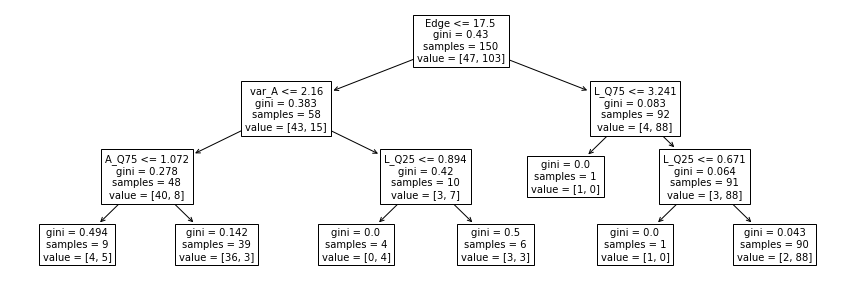

In [55]:
test = merged(dataset)
mean_L, var_L, var_A, edges, vertices, cycle, no_pentagon, \
    no_hexagon, Diameter_list, Radius_list, No_periphery_list, No_center_list, \
    L_Q25, L_Q50, L_Q75, A_Q25, A_Q50, A_Q75 = test.sum_Attributes()
attribute_data={'Vertex':vertices,'Edge':edges,'Diameter':Diameter_list, 'Radius':Radius_list, 'Periphery':No_periphery_list,\
                'Center':No_center_list,'Pentagon':no_pentagon, 'Hexagon':no_hexagon,'Cycle':cycle, 'mean_L':mean_L, \
               'var_L':var_L, 'var_A':var_A, 'L_Q25':L_Q25, 'L_Q50':L_Q50, 'L_Q75':L_Q75, 'A_Q25':A_Q25, 'A_Q50':A_Q50,\
               'A_Q75':A_Q75}
features=['Vertex','Edge','Diameter', 'Radius', 'Periphery', 'Center', 'Pentagon','Hexagon','Cycle', 'mean_L',\
               'var_L', 'var_A', 'L_Q25', 'L_Q50', 'L_Q75', 'A_Q25', 'A_Q50', 'A_Q75']
attributes=pd.DataFrame(attribute_data,columns=features)
target=[]
for i in range(np.size(dataset)):
    target.append(dataset[i]['class'])
    
Xtrain, Xtest, Ytrain, Ytest = train_test_split(attributes, target, test_size=0.2, random_state=0)
mytree = tree.DecisionTreeClassifier(random_state=0,max_depth=3)
modeldb = mytree.fit(Xtrain, Ytrain)
plt.figure(figsize=(15,5))
tree.plot_tree(modeldb,feature_names=features,fontsize=10)
# plt.savefig('Q1_tree.png')
plt.show()